In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import os

import numpy as np

import plotly.express as px


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
df = pd.read_csv('/Users/jmmill29/Desktop/creditcard.csv')

In [5]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [4]:
# Create VAE class, subclassing nn.Module from Pytorch. 

class VAE_deep(nn.Module):

    def __init__(self, input_dim, latent_dim):
        super(VAE_deep, self).__init__()

        
        # Input tensor size B x input_dim
        # Output tensor size B x latent_dim * 2
        # Output is mean and diagonal covariance matrix entries for Gaussian in latent space ( R^{latent_dim} )

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, latent_dim * 4),
            nn.ReLU(),
            nn.Linear(latent_dim * 4 , latent_dim * 8),
            nn.ReLU(),
            nn.Linear(latent_dim * 8 , latent_dim * 16),
            nn.ReLU(),
            nn.Linear(latent_dim * 16 , latent_dim * 8),
            nn.ReLU(),
            nn.Linear(latent_dim * 8 , latent_dim * 4),
            nn.ReLU(),
            nn.Linear(latent_dim * 4 , latent_dim * 2),
        )


        # Input tensor size B x latent_dim
        # Output tensor size B x input_dim * 2
        # Output is mean and diagonal precision matrix (stability) entries for Gaussian in input space ( R^{input_dim} )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, input_dim * 4),
            nn.ReLU(),
            nn.Linear(input_dim * 4 , input_dim * 8),
            nn.ReLU(),
            nn.Linear(input_dim * 8 , input_dim * 16),
            nn.ReLU(),
            nn.Linear(input_dim * 16 , input_dim * 8),
            nn.ReLU(),
            nn.Linear(input_dim * 8 , input_dim * 4),
            nn.ReLU(),
            nn.Linear(input_dim * 4 , input_dim * 2),
        )

        self.softplus = nn.Softplus()


      
    
    def encode(self, x, eps: float = 1e-8):

        # Get parameter vectors for latent Gaussian, ensure positive definite entries for covariance, embed entries in matrix
        # return distribution object, mean, log variance  

        z_params = self.encoder(x)
        mu, logvar = torch.chunk(z_params, 2, dim = -1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
    
    
        return [torch.distributions.MultivariateNormal(mu, scale_tril = scale_tril), mu, logvar]


      
    
    def reparam(self, dist):

        # Use built-in Pytorch reparameterization trick functionality to sample from distribution object  


        return dist.rsample()


    

    def decode(self, z):

        # Get mean and log precision for input space from latent representation

        x_params = self.decoder(z)
        mu, logprec = torch.chunk(x_params, 2, dim = -1)
        

        return [mu, logprec]

    
    

    def forward(self, x):

        # Get latent space parameter vectors, sample from latent space using these vectors, get reconstructed input parameter
        # vectors from latent space sample, return all vectors

        z_dist, z_mu, z_logvar = self.encode(x)
        z = self.reparam(z_dist)
        x_mu, x_logprec = self.decode(z)


        return [x_mu, x_logprec, z_mu, z_logvar] 



    def loss_function(self, x, params, prior_scale,
                                        recon_penalty,
                                        kld_penalty): 
                                        
                                        # prior_scale is float to constrain the Guassian prior over latent space
                                        # recon_penalty constrains the recon_loss
                                        # kld_penalty constrains the kld loss

        # Minimize the negative elbo (reconstruction score + KL Divergence between Gaussion prior and posterior
        # over latent sapce)

        x_mu, x_logprec, z_mu, z_logvar = params

        l = x - x_mu
        l2 = l**2

        recon_loss = torch.mean(0.5 * torch.sum(x_logprec.exp() * l2 - x_logprec  , dim = 1), dim = 0)
        scale = z_mu ** 2 + z_logvar.exp()
        scale = prior_scale * scale
        kld = torch.sum(1 + z_logvar - scale, dim = 1)
        kld =  - np.log(prior_scale) + kld
        kld = torch.mean(- 0.5 * kld, dim = 0)


        return recon_penalty * recon_loss +  kld_penalty * kld   

     
    def test_reconstruction_loss(self, x):

        # Get reconstruction scores for input tensor. Input is tensor of size N x input_dim where
        # N is the size of either train or test set. Output is tensor of size N. Average over 10
        # reconstruction samples to obtain stable estimate

       x_mu, x_logprec, z_mu, z_logvar = self.forward(x)

       l = x - x_mu
       l2 = l**2

       recon_loss = 0.5 * torch.sum(x_logprec.exp() * l2 - x_logprec  , dim = 1)

       for i in range(0,9):
              x_mu, x_logprec, z_mu, z_logvar = self.forward(x)

              l = x - x_mu
              l2 = l**2

              recon_loss_2 = 0.5 * torch.sum(x_logprec.exp() * l2 - x_logprec  , dim = 1)
              recon_loss = recon_loss + recon_loss_2

       
       return recon_loss/10

    
    def test_threshold(self, train_tensor, test_tensor, threshold_3, threshold_2, threshold_1):
                                                        # threshold_3 > threshold_2 > threshold_1; float

        # Test percentages of fraud and non-fraud reconstruction scores in test set that lie above a given percentile
        # of reconstruction scores from train set. This is the risk class segmentation step


        x = self.test_reconstruction_loss(train_tensor)
        y = self.test_reconstruction_loss(test_tensor)
        
        compare_3 = (y[y_test.loc[y_test == 1].index] > torch.quantile(x, threshold_3)).float()
        compare_2 = (y[y_test.loc[y_test == 1].index] > torch.quantile(x, threshold_2)).float()
        compare_1 = (y[y_test.loc[y_test == 1].index] > torch.quantile(x, threshold_1)).float()


        compare_non_3 = (y[y_test.loc[y_test == 0].index] > torch.quantile(x, threshold_3)).float()
        compare_non_2 = (y[y_test.loc[y_test == 0].index] > torch.quantile(x, threshold_2)).float()
        compare_non_1 = (y[y_test.loc[y_test == 0].index] > torch.quantile(x, threshold_1)).float()

        return [compare_3.mean(), 
                compare_2.mean(), 
                compare_1.mean(), 
                compare_non_3.mean(), 
                compare_non_2.mean(), 
                compare_non_1.mean()]

    

    def reconstruct(x, model):

        # Reconstruct a given input tensor according to the generative model and return its associated
        # reconstruction score 
        
        z_dist, z_mu, z_logvar = model.encode(x)
        z = z_dist.sample()
        x_mu, x_logprec = model.decode(z)

        x_prec = torch.diag_embed(x_logprec.exp())
        x = torch.distributions.MultivariateNormal(x_mu, precision_matrix= x_prec).sample()

        l = x - x_mu
        l2 = l**2

        recon_loss = 0.5 * torch.sum(x_logprec.exp() * l2 - x_logprec, dim = 1)


        return [x, recon_loss]



In [5]:
# Define training pipeline

def vae_train(model, optimizer, epochs, prior_scale, recon_penalty, kld_penalty, device):
    loss_hist_train = [0] * epochs 
    for epoch in range(epochs):
        for data in train_dl:
            optimizer.zero_grad()
            params = model(data)
            loss = model.loss_function(data, params, prior_scale, recon_penalty, kld_penalty)
            loss.backward()
            optimizer.step() 
            loss_hist_train[epoch] += loss.item()
        print(epoch)
        print(loss_hist_train[epoch])

    return loss_hist_train
            

In [26]:
# Perform k-fold cross validation on risk segmentation. Set k_fold 

k_fold = 3


time_drop = True
# Boolean to either save or drop the 'Time' feature from the dataset. Given that we are maximizing the elbo and we are assuming
# independent data in the log-liklihood, the time variable seems to only add noise to the features. Training confirms this, and so
# the final model is trained without the 'Time' feature. 


fraud_abv_thres = [0] * 3
non_fraud_abv_thres = [0] * 3

for i in range(0, k_fold):

    # Make train-test split

    df_features = df.drop(['Class'], axis = 1)
    df_labels = df.loc[:, 'Class']

    X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size = 0.05, stratify=df_labels)
    # We supply a large percentage of data to the train set to enable best learning for the generative model and to aid
    # in subsequent visualizations of reconstruction scores and latent space

    # While the stratification is not strictly neccessary, it ensures some fraud cases in the train set and avoids a Runtime error in
    # the following code

    # Move fraud cases from train set to test set. This ensures that the VAE is only exposed to non-fraud cases during training
    # which focuses the latent represenation away from such cases, enabling better differentation.

    ones_indices = y_train.loc[y_train == 1].index

    X_test = pd.concat([X_test, X_train.loc[ones_indices,:]], axis = 0)
    y_test = pd.concat([y_test, y_train[ones_indices]])

    X_train_clean = X_train.drop(ones_indices)
    y_train_clean = y_train.drop(ones_indices)

    X_train_clean = X_train_clean.reset_index(drop = True)
    X_test = X_test.reset_index(drop = True)
    y_train_clean = y_train_clean.reset_index(drop = True)
    y_test = y_test.reset_index(drop = True)


    if time_drop:
        X_train_clean = X_train_clean.drop(['Time'], axis = 1)
        X_test = X_test.drop(['Time'], axis = 1)
        

    # Standardize data, using stats from train set to transform test set to avoid bleed from test to training. 

    # All variables besides 'Amount' and 'Time' are already centered, so we only need to scale. 
    # If time_drop boolean is True, start at column 0. If time_drop boolean is False, start at column 1
    for i in range(not time_drop, len(X_train_clean.columns)-1):
        std = np.sqrt(X_train_clean.iloc[:,i].var())
        X_train_clean.iloc[:,i] = X_train_clean.iloc[:,i] / std
        X_test.iloc[:,i] = X_test.iloc[:,i] / std

    # Center and scale 'Amount'
    mean = X_train_clean.loc[:, 'Amount'].mean()
    std = np.sqrt(X_train_clean.loc[:, 'Amount'].var())
    X_train_clean.loc[:, 'Amount'] = (X_train_clean.loc[:, 'Amount'] - mean) / std
    X_test.loc[:, 'Amount'] = (X_test.loc[:, 'Amount'] - mean) / std

    if not time_drop:
        mean = X_train_clean.loc[:, 'Time'].mean()
        std = np.sqrt(X_train_clean.loc[:, 'Time'].var())
        X_train_clean.loc[:, 'Time'] = (X_train_clean.loc[:, 'Time'] - mean) / std
        X_test.loc[:, 'Time'] = (X_test.loc[:, 'Time'] - mean) / std


    # Create train and test tensors

    train_tensor_clean = torch.Tensor(np.array(X_train_clean))
    test_tensor = torch.Tensor(np.array(X_test))

    fraud_model = VAE_deep(input_dim = len(X_train_clean.columns) , latent_dim = 3)
    learning_rate = 1e-4
    batch_size = 1024
    optimizer = torch.optim.AdamW(fraud_model.parameters(), lr = learning_rate)
    train_dl = DataLoader(train_tensor_clean, batch_size, shuffle = True)


    # train the generative model
    history = vae_train(model=fraud_model, 
                        optimizer=optimizer, 
                        epochs=50, 
                        prior_scale=1,
                        recon_penalty=1,
                        kld_penalty=1, 
                        device=device)

    results = fraud_model.test_threshold(train_tensor_clean, test_tensor, .95, .9, .85)

    fraud_abv_thres[0] += results[0]
    fraud_abv_thres[1] += results[1]
    fraud_abv_thres[2] += results[2]
    non_fraud_abv_thres[0] += results[3]
    non_fraud_abv_thres[1] += results[4]
    non_fraud_abv_thres[2] += results[5]


for i in range(0, 3):
    fraud_abv_thres[i] = fraud_abv_thres[i]/k_fold

for i in range(0, 3):
    non_fraud_abv_thres[i] = non_fraud_abv_thres[i]/k_fold

print('Frauds in Class 3 Risk:', fraud_abv_thres[0])
print('Frauds in Class 2 Risk:', fraud_abv_thres[1])
print('Frauds in Class 1 Risk:', fraud_abv_thres[2])
print('Non-frauds impacted by Class 3 Risk:', non_fraud_abv_thres[0])
print('Non-frauds impacted by Class 2 Risk:', non_fraud_abv_thres[1])
print('Non-frauds impacted by Class 1 Risk:', non_fraud_abv_thres[2])

    

0
3836.6945009231567
1
3394.0976762771606
2
2168.199052333832
3
1917.849338054657
4
1736.431260585785
5
1587.09720993042
6
1420.259060382843
7
1273.2922539710999
8
1166.9359664916992
9
1096.619820356369
10
1041.0713515281677
11
1000.1880216598511
12
964.6672205924988
13
932.0661327838898
14
900.2364554405212
15
870.8169310092926
16
841.8536503314972
17
812.0978298187256
18
784.7878932952881
19
763.046458363533
20
741.5382293462753
21
722.1790598630905
22
701.3789722919464
23
680.4704428911209
24
663.6441676616669
25
648.5141246318817
26
631.0083216428757
27
615.7494411468506
28
601.2494534254074
29
588.7751137018204
30
573.3055394887924
31
558.0900546312332
32
546.7242304086685
33
533.8650062084198
34
524.0675163269043
35
509.94692093133926
36
499.80332666635513
37
486.459508895874
38
474.65934270620346
39
463.8169198036194
40
453.5550246834755
41
444.4478607773781
42
431.69907104969025
43
426.3499084711075
44
412.35237830877304
45
406.5430125594139
46
397.6544933319092
47
393.43010449

0
2841.6971559524536
1
2804.297826766968
2
1915.8280491828918
3
1565.7201948165894
4
1408.6777110099792
5
1285.2466354370117
6
1140.831326007843
7
1030.1261639595032
8
953.24818110466
9
876.8621163368225
10
820.4712750911713
11
781.8892912864685
12
748.5177018642426
13
712.3923244476318
14
683.3337497711182
15
655.4484033584595
16
634.8585679531097
17
616.724872469902
18
601.3216731548309
19
588.6550137996674
20
575.3423883914948
21
563.2419637441635
22
550.7264150381088
23
541.4082461595535
24
530.3877890110016
25
519.8669288158417
26
512.920019865036
27
500.4147387742996
28
490.22829163074493
29
482.9720996618271
30
473.6106126308441
31
467.5300062894821
32
456.5540827512741
33
448.23579823970795
34
440.69213902950287
35
431.5616825222969
36
426.802005648613
37
418.3808928132057
38
409.1306324005127
39
401.6724418401718
40
398.2294521331787
41
390.8206659555435
42
383.539930164814
43
378.8119758963585
44
373.9711766242981
45
367.23903000354767
46
361.20392817258835
47
355.57892274856

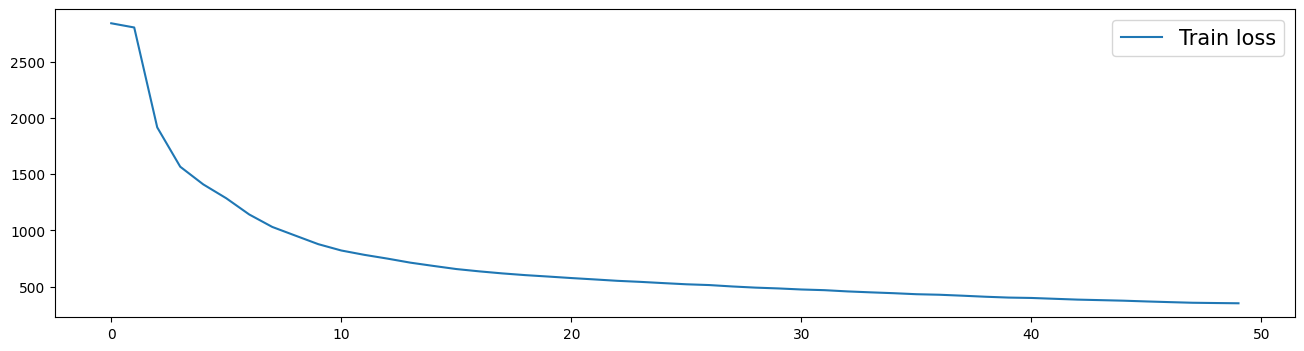

In [290]:
# Plot most recent train run

fig = plt.figure(figsize=(16, 4)) 
plt.plot(history)
plt.legend(['Train loss'], fontsize=15)

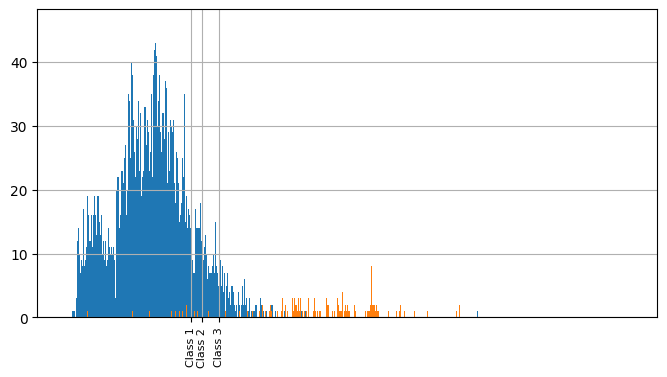

In [48]:
# Visualize the distribution of reconstruction scores on the test set
# stratified according to fraud class and view placement in relation to risk tier
# percentiles established by train set

recon_score_dist_df = pd.DataFrame({'Scores': fraud_model.test_reconstruction_loss(test_tensor).detach().numpy() ,
                    'Class': y_test})

train_reconstruction_loss = fraud_model.test_reconstruction_loss(train_tensor_clean)


for group in recon_score_dist_df['Class'].unique():
    
    filtered_viz = recon_score_dist_df[recon_score_dist_df['Class']==group]

    filtered_viz['Scores'].hist(figsize=(8, 4), bins = 2000)



plt.xticks([torch.quantile(train_reconstruction_loss, .85).item(), 
            torch.quantile(train_reconstruction_loss, .9).item(), 
            torch.quantile(train_reconstruction_loss, .95).item()], ['Class 1', 'Class 2', 'Class 3'])

plt.xticks(rotation=90)
plt.xticks(fontsize=8)
plt.yticks(fontsize=10)

plt.show()



In [23]:
# Create a dataframe of the latent space representations of the test set
# append the risk class classification and the fraud class

latent_rep_dist = fraud_model.encode(test_tensor)[0]
names = ['x', 'y', 'z']
latent_rep = pd.DataFrame(fraud_model.reparam(latent_rep_dist).detach().numpy(), columns=names)
y = fraud_model.test_reconstruction_loss(test_tensor)

x = fraud_model.test_reconstruction_loss(train_tensor_clean)
mask_3 = (y > torch.quantile(x, .95)).float()
mask_2 = (y > torch.quantile(x, .9)).float()
mask_1 = (y > torch.quantile(x, .85)).float()

class_vector = mask_1 + mask_2 + mask_3

latent_rep['Risk Class'] = class_vector.detach().numpy()
latent_rep['Fraud Class'] = y_test



In [24]:
# Visualize the latent space representation and look for potential clustering along fraud class

fig = px.scatter_3d(latent_rep, x='x', y='y', z='z',
              color='Fraud Class', opacity=0.5)
fig.show()

In [25]:
# Visualize the latent space representation and look for potential clustering along risk class

fig2 = px.scatter_3d(latent_rep, x='x', y='y', z='z',
              color='Risk Class', opacity=0.5)
fig2.show()